# Load Libraries

In [4]:
library(dplyr)
library(caret)
library(lattice)
library(ggplot2)
library(stats)
library(Hmisc)
library(car)
library(leaps)
library(outliers)
library(kknn)
library(knitr)
library(psych)
library(corrplot)
library(tidyverse)
library(cli)
library(devtools)
library(rpart)
library(pROC)
library(nnet)
library(foreign)
library(reshape2)
library(lattice)
library(ggplot2)
library(comprehenr)
library(gridExtra)
library(MASS)
library(aod)
library(e1071)
#library(factoextra)
#conda install -c conda-forge r-factoextra 
library(class)
library(randomForest)
library(rpart)
library(rpart.plot)
library(gbm)

Loaded gbm 2.1.5


# Load Data

In [5]:
setwd("~/Downloads/Datasets/7406/Project")

white <- read.csv(file = "winequality_white.csv", head = TRUE, sep=";")
red <- read.csv(file = "winequality_red.csv", head = TRUE, sep=";")

In [ ]:
#wine <- rbind(white, red)
wine <- red


wine.pr <- wine[1:11]

#wine <- read.csv(file = "winequality_red.csv", head = TRUE, sep=";")
wine$quality <- ifelse(wine$quality>= 6, 1,0)
wine$quality <- as.factor(wine$quality)

summary(wine)


#Random sampling
set.seed(7406)

test <- 0.8

ff <- floor((1 - test)*nrow(wine))

ind <- sample(nrow(wine), ff, replace = FALSE)

# Training and Test datasets
wine_train <- wine[ind,]
wine_test <- wine[-ind,]

# Exploratory Data Analysis

In [ ]:
head(wine, 3)
str(wine)
summary(wine)

nobs <- nrow(wine)

In [ ]:
dim(white)

In [ ]:
dim(red)

In [ ]:
summary(wine)

In [ ]:
na_count <- sapply(wine, function(y) sum(length(which(is.na(y)))))
na_count

# OUTLIERS

In [ ]:
par(mfrow = c(2,2))
qqnorm(wine$quality, pch = 1, frame = FALSE, main = 'QQ-plot - QUALITY')
qqline(wine$quality, col = "blue", lwd = 2)
boxplot(wine$quality, main = 'Original data - Outliers')


In [ ]:
grubbs.test(wine$quality, type =10)

Our dataset does not have any missing values. 

Our response variable "Quality" is a categorical one with the ranks from 1 to 10.
The range of values (min/max) across the variables does not require scaling or normalization. All predictors are numerical.


In [ ]:
corrplot(cor(wine[1:(length(wine))]), method="number")

Covariance Matrix

There is some significant multicollineraity between several variables:

density - alcohol
total.sulfur.dioxide - free.sulfur.dioxide
density - residual.sugar
residual.sugar - total.sulfur.dioxide
density - fixed.acidity

Certain predictors will have to be removed. Most likely candidates are:

free.sulfur.dioxide
residual.sugar
fixed.acidity
alcohol


In [ ]:
par(mfrow = c(2,2))

hist(wine$quality,xlab = 'Quality', main = "Distribution of Red Wine Quality")
#hist(wine[wine$type == "white",]$quality,xlab = 'Quality', main = "Distribution of White Wine Quality")
#hist(wine[wine$type == "red",]$quality,xlab = 'Quality', main = "Distribution of Red Wine Quality")

In [ ]:
attach(wine)
par(mfrow = c(3,2))

plot(density, fixed.acidity)
plot(volatile.acidity, total.sulfur.dioxide)
plot(residual.sugar, density)
plot(residual.sugar, total.sulfur.dioxide)
plot(free.sulfur.dioxide, total.sulfur.dioxide)
plot(density, alcohol)

In [ ]:
par(mfrow = c(3,3))
boxplot(fixed.acidity ~ quality)
boxplot(volatile.acidity ~ quality)
boxplot(citric.acid ~ quality)
boxplot(residual.sugar ~ quality)
boxplot(chlorides ~ quality)
boxplot(free.sulfur.dioxide ~ quality)
boxplot(total.sulfur.dioxide ~ quality)
boxplot(density ~ quality)
boxplot(pH ~ quality)
boxplot(sulphates ~ quality)
boxplot(alcohol ~ quality)

MODELING

We will start with converting scale values for "quality" from 1-10 to a binary system (0,1). A 1 will represent good wine and a 0 will represent "bad" wine.
We will analyze initial dataset using ordinal logistic regression at the end of this research.

At first, we will use logistic regression, KNN, SVM, Trees etc..

For Logistic regression, we romoved the following non-significant predictors:

density
fixed.acidity
residual.sugar

This is well-aligned with the conclusions from the covariance matrix


# Logistic Regression

### Logistic Regression with All Predictors

In [ ]:
lgall <- glm(quality ~ ., data = wine, family = binomial(link="logit"))
summary(lgall)

In [ ]:
wald.test(Sigma = vcov(lgall), b = coef(lgall), Terms = 1:length(lgall$coef))

Since p-value = 0.0, then there are no non-significant coefficients.

In [ ]:
aiclgall <- round(AIC(lgall),1)
biclgall <- round(BIC(lgall),1)

print(paste('AIC = ', aiclgall, '     BIC = ', biclgall))

In [ ]:
print('Significance Ranking')
round(vif(lgall),3)

In [ ]:
# Confidence Intervals

exp(cbind(OR = coef(lgall), confint(lgall)))

In [ ]:
#print('Error')
prediction <- predict(lgall,wine[,1:11], type = "response")
prediction <- ifelse(prediction>= .5, 1,0)

In [ ]:
cm <- confusionMatrix(wine$quality, as.factor(prediction))
print(cm)

print(paste('Accuracy = ', round(cm$overall['Accuracy'],3) ))

### Logistic Regression with Significant Predictors

In [ ]:
lgsig <- glm(quality ~ .- residual.sugar - fixed.acidity - density, data = wine, family = binomial(link="logit"))
summary(lgsig)

In [ ]:
wald.test(Sigma = vcov(lgsig), b = coef(lgsig), Terms = 1:length(lgsig$coef))

In [ ]:
aiclgsig <- round(AIC(lgsig),1)
biclgsig <- round(BIC(lgsig),1)

print(paste('AIC = ', aiclgsig, '     BIC = ', biclgsig))

In [ ]:
print('Significance Ranking')
round(vif(lgsig),3)

In [ ]:
exp(cbind(OR = coef(lgsig), confint(lgsig)))

In [ ]:
#print('Error')
predictions <- predict(lgsig,wine[,1:11], type = "response")
predictions <- ifelse(predictions >= .5, 1,0)

cm <- confusionMatrix(wine$quality, as.factor(predictions))
print(cm)

print(paste('Accuracy = ', round(cm$overall['Accuracy'],3) ))

# KMEANS

In [ ]:
#wine.pr$quality <- as.numeric(wine.pr$quality)

num <- 15
nst <- 6 #Initial number of centroids

res_fin <- matrix(0, num, 1) 

for (k in 1:num) {
  
    kmd <- kmeans(wine.pr, k, nstart = nst)
    kvl <- kmd$tot.withinss
    res_fin[k] <- kvl
}

plot(res_fin, type = 'l', ylab = 'WSS', xlab = 'K',
     main = 'Optimal K value for KMEANS')


In [ ]:
# WSS Method
set.seed(7406)

kbest <- 4 # The best K Value
fitK = kmeans(wine.pr, kbest, nstart = 5)
plot(wine,col = fitK$cluster)



In [ ]:
ggplot(wine, aes(x = fixed.acidity, y = volatile.acidity, shape = quality, col = quality))+geom_point()
ggplot(wine, aes(x = density, y = alcohol, shape = quality, col = quality))+geom_point()
ggplot(wine, aes(x = free.sulfur.dioxide, y = total.sulfur.dioxide, shape = quality, col = quality))+geom_point()

# The data is not separable. Thus KNN is preferred choice over SVM


In [ ]:
fitK

In [ ]:
library(factoextra)
fviz_cluster(fitK, data = wine.pr)

# KNN

In [ ]:
#Random sampling
set.seed(7406)

test <- 0.8

ff <- floor((1 - test)*nrow(wine))

ind <- sample(nrow(wine), ff, replace = FALSE)

# Training and Test datasets
wine_train <- wine[ind,]
wine_test <- wine[-ind,]

In [ ]:
i=1
k.optm=1

for (i in 1:28){
    knn.mod <- knn(train=wine_train, test=wine_test, cl=wine_train$quality, k=i)
    
    k.optm[i] <- 100 * sum(wine_test$quality == knn.mod)/NROW(wine_test$quality)
    
    k=i
    
    cat(k,'=',k.optm[i],'
')}

plot(k.optm, type="b", xlab="K- Value",ylab="Accuracy level")

In [ ]:
knn <- knn(train=wine_train, test=wine_test, cl=wine_train$quality, k=3)

In [ ]:
cm <- confusionMatrix(wine_test$quality, as.factor(knn))
print(cm)

print(paste('Accuracy = ', round(cm$overall['Accuracy'],3) ))

# SVM

In [ ]:
# Linear Classifier

classifier = svm(formula = quality ~ .,
                 data = wine_train,
                 type = 'C-classification',
                 kernel = 'linear')
summary(classifier)

In [ ]:
predictions <- predict(classifier, newdata = wine_test[,1:11])
cm <- confusionMatrix(wine_test$quality, as.factor(predictions))
print(cm)
print(paste('Accuracy = ', round(cm$overall['Accuracy'],3) ))

In [ ]:
# Non-Linear Classifier

classifier_rb = svm(formula = quality ~ .,
                 data = wine_train,
                 type = 'C-classification',
                 kernel = 'radial')
summary(classifier_rb)


predictions_rb <- predict(classifier_rb, newdata = wine_test[,1:11])
cmrb <- confusionMatrix(wine_test$quality, as.factor(predictions_rb))
print(cmrb)
print(paste('Accuracy = ', round(cmrb$overall['Accuracy'],3) ))

In [ ]:
# Linera Classifier with variable C parameter

# To get graphical outputs
results_c <- matrix(rep(0, len=14), nrow = 2)

c_value = c(1, 2, 3, 5, 10, 20, 50) # chosen C values to select from
cl = length(c_value) 

for (j in 1:cl) {
    
    cj <- c_value[j]
    results_c[1,j] <- cj
    
    # Build the Model for different C values
#    msvm = ksvm(as.matrix(wine_train [,1:11]), wine_train$quality),
#                type = 'C-svc', kernel = 'vanilladot', C = cj, scaled = TRUE)
    
    msvm <- svm(formula = quality ~ .,
                data = wine_train,
                type = 'C-classification',
                kernel = 'linear',
                cost = cj,
                scaled = TRUE)
    
    print(msvm) # display the model
    
  # calculate a1...am
#  a <- colSums(msvm@xmatrix[[1]] * msvm@coef[[1]])
#  print(a)
    
  # calculate a0
#  a0 <- -msvm@b
#  print(a0)
    
  # Model Prediction and Accuracy
  pred <- predict(msvm,wine_test[,1:11])
  prediction = sum(pred == wine_test$quality) / nobs
  results_c[2,j] <- prediction
    
}

plot(results_c[1,], results_c[2,],main="Accuracy for C Values, Linear",
     ylab = "Accuracy, %", xlab = "C", type = "l", col = "red")

# Ordinal Regression

In [ ]:
ord_mod <- polr(as.factor(quality) ~., data = wine.pr, Hess = TRUE)
summary(ord_mod)


In [ ]:
(ctable <- coef(summary(ord_mod)))

In [ ]:
## calculate and store p values
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2

## combined table
(ctable <- cbind(ctable, "p value" = p))

In [ ]:
#(ci <- confint(ord_mod)) # default method gives profiled CIs

In [ ]:
confint.default(ord_mod) # CIs assuming normality

# If the move from 2.5% to 97.% includes a zero (a sign change) then this coefficient is NOT statistically significant

In [ ]:
## odds ratios - These coefficients are called proportional odds ratios
#exp(cbind(OR = coef(ord_mod), ci))

In [ ]:
# Let's rerun the regression with only significant predictors

ord_mods <- polr(as.factor(quality) ~. -citric.acid - chlorides - total.sulfur.dioxide, data = wine.pr, Hess = TRUE)
summary(ord_mods)


In [ ]:
(ctable1 <- coef(summary(ord_mods)))

In [ ]:
## calculate and store p values
p <- pnorm(abs(ctable1[, "t value"]), lower.tail = FALSE) * 2

## combined table
(ctable1 <- cbind(ctable1, "p value" = p))

In [ ]:
#(ci1 <- confint(ord_mods)) # default method gives profiled CIs

In [ ]:
ci1 <- confint.default(ord_mods) # CIs assuming normality
ci1

# All predictors are significant

In [ ]:
## odds ratios - These coefficients are called proportional odds ratios
exp(cbind(OR = coef(ord_mods), ci1))

In [ ]:
# Proportional Odds

sf <- function(y) {
  c('Y>=0' = qlogis(mean(y >= 0)),
    'Y>=1' = qlogis(mean(y >= 1)),
    'Y>=2' = qlogis(mean(y >= 2)),
    'Y>=3' = qlogis(mean(y >= 3)),
    'Y>=4' = qlogis(mean(y >= 4)),
    'Y>=6' = qlogis(mean(y >= 6)),
    'Y>=7' = qlogis(mean(y >= 7)),
    'Y>=8' = qlogis(mean(y >= 8)),
    'Y>=9' = qlogis(mean(y >= 9)))
}

(s <- with(wine, summary(as.numeric(quality) ~ fixed.acidity + volatile.acidity + residual.sugar + 
                           free.sulfur.dioxide + density + pH + sulphates + alcohol, fun=sf)))

In [ ]:
# Example

glm(I(as.numeric(quality) >= 4) ~ density, family ="binomial", data = wine)

In [ ]:
#s[, 4] <- s[, 4] - s[, 3]
#s[, 3] <- s[, 3] - s[, 3]
#s

In [ ]:
glm(I(as.numeric(quality) >= 6) ~ density, family ="binomial", data = wine)

# Random Forest

In [ ]:
rf <- randomForest(quality~., data=wine_train, proximity=TRUE) 
predictions <- predict(rf, wine_test)
confusionMatrix(predictions, wine_test$quality)

In [ ]:
plot(rf)

In [ ]:
hist(treesize(rf),
     main = "No. of Nodes for the Trees",
     col = "green")


In [ ]:
    varImpPlot(rf,
               sort = T,
               n.var = 10,
               main = "Top 10 - Variable Importance")

In [ ]:
importance(rf)

# Decision Tree

In [ ]:
fit <- rpart(quality~., data = wine_train, method = 'class')
rpart.plot(fit, extra = 106)

In [ ]:
predictions <- predict(fit, wine_test, type = 'class')
cm <- confusionMatrix(wine_test$quality, as.factor(predictions))
print(cm)
print(paste('Accuracy = ', round(cm$overall['Accuracy'],3) ))

BOOSTING

All variables

[1] 281

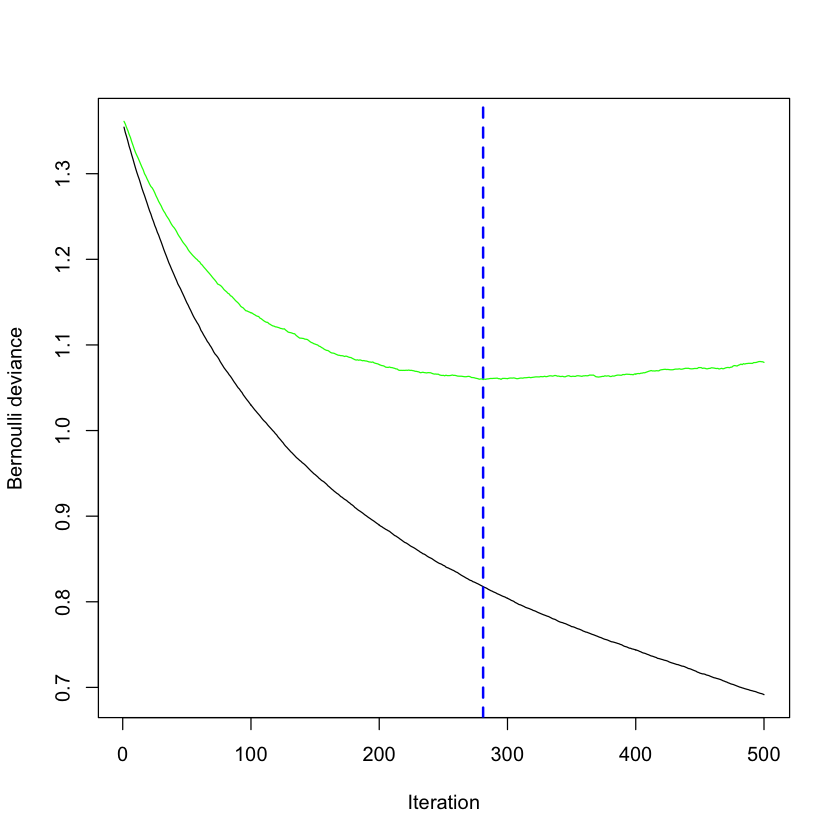

In [17]:
# Boosting
set.seed(7406)

#wine <- rbind(white, red)
wine <- red


wine.pr <- wine[1:11]

#wine <- read.csv(file = "winequality_red.csv", head = TRUE, sep=";")
wine$quality <- ifelse(wine$quality>= 6, 1,0)

#Random sampling
set.seed(7406)

test <- 0.8

ff <- floor((1 - test)*nrow(wine))

ind <- sample(nrow(wine), ff, replace = FALSE)

# Training and Test datasets
wine_train <- wine[ind,]
wine_test <- wine[-ind,]

gbm.train <- gbm(quality ~ .,
                 data=wine_train,
                 distribution = 'bernoulli',
                 n.trees = 500, 
                 shrinkage = 0.01, 
                 interaction.depth = 3,
                 cv.folds = 5,
                 n.cores = NULL,verbose = FALSE)
                  
## Model Inspection 
## Find the estimated optimal number of iterations
perf_gbm1 = gbm.perf(gbm.train, method="cv") 
perf_gbm1

,var,rel.inf
alcohol,alcohol,26.830706
sulphates,sulphates,17.951417
volatile.acidity,volatile.acidity,10.954048
total.sulfur.dioxide,total.sulfur.dioxide,8.021901
chlorides,chlorides,7.581519
pH,pH,6.381061
density,density,6.001086
fixed.acidity,fixed.acidity,5.389601
residual.sugar,residual.sugar,4.237370
citric.acid,citric.acid,4.205721


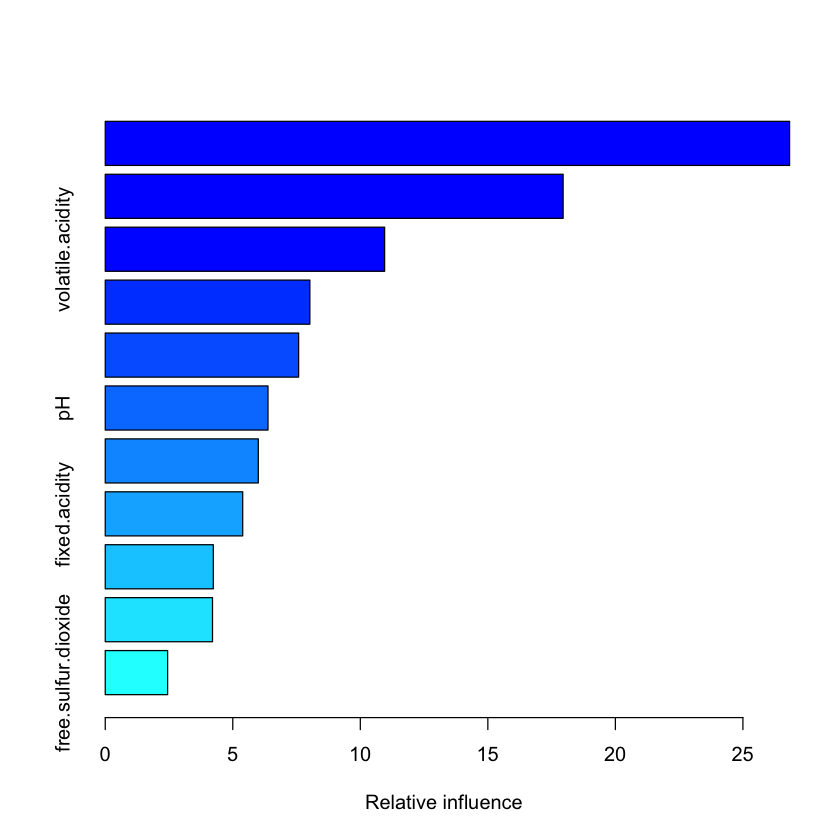

In [18]:
summary(gbm.train)

In [19]:
## Training error
pred1gbm <- predict(gbm.train,newdata = wine_train, n.trees=perf_gbm1, type="response")

y1hat <- ifelse(pred1gbm < 0.5, 0, 1)

bst_train_err <- round(mean(y1hat != wine_train$quality),4)
print(paste('Boost Training Error = ', bst_train_err))

## Testing Error
y2hat <- ifelse(predict(gbm.train,newdata = wine_test, n.trees=perf_gbm1, type="response") < 0.5, 0, 1)
bst_test_err <- round(mean(y2hat != wine_test$quality),4)
print(paste('Boost Testing Error = ', bst_test_err))



[1] "Boost Training Error =  0.2006"
[1] "Boost Testing Error =  0.2586"


Only SIGNIFICANT variables

[1] 236

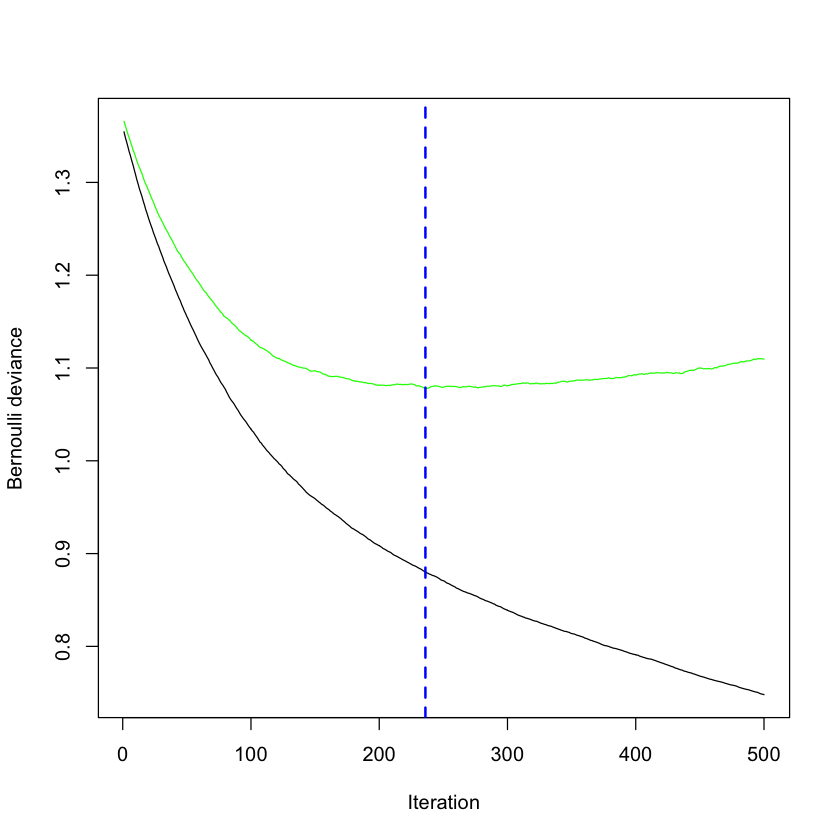

In [20]:
gbm.sig <- gbm(quality ~ . - residual.sugar - fixed.acidity - density - citric.acid - pH,
                 data=wine_train,
                 distribution = 'bernoulli',
                 n.trees = 500, 
                 shrinkage = 0.01, 
                 interaction.depth = 3,
                 cv.folds = 5,
                 n.cores = NULL,verbose = FALSE)
                  
## Model Inspection 
## Find the estimated optimal number of iterations
perf_gbm2 = gbm.perf(gbm.sig, method="cv") 
perf_gbm2

In [21]:
## Training error
pred11gbm <- predict(gbm.sig,newdata = wine_train, n.trees=perf_gbm2, type="response")

y11hat <- ifelse(pred11gbm < 0.5, 0, 1)

bst1_train_err <- round(mean(y11hat != wine_train$quality),4)
print(paste('Boost Training Error = ', bst1_train_err))

## Testing Error
y22hat <- ifelse(predict(gbm.sig,newdata = wine_test, n.trees=perf_gbm2, type="response") < 0.5, 0, 1)
bst2_test_err <- round(mean(y22hat != wine_test$quality),4)
print(paste('Boost Testing Error = ', bst2_test_err))



[1] "Boost Training Error =  0.2163"
[1] "Boost Testing Error =  0.2695"


# Implementation of Monte Carlos CV for: Logistic Regression, KNN, SVM, Ordinal Regression, Random Forest, Decision Tree

In [ ]:
set.seed(7406)
n = dim(wine)[1]; 
n1 = round(n/5);
B= 100;

b_index <- list()
te1 <- list()
te2 <- list()
te3 <- list()
te4 <- list()
te5 <- list()
te6 <- list()



for (b in 1:B){
### randomly select n1 observations as a new training  subset in each loop
    flag <- sort(sample(1:n, n1));
    wine_train_temp <- wine[-flag,];  ## temp training set for CV
    wine_test_temp  <- wine[flag,]; ## temp testing set for CV
    
    b_index <- c(b_index, b)
     
    # Model 1: Logistic Regression with All Predictors
    lgall <- glm(quality ~ ., data = wine_train_temp, family = binomial(link="logit"))
    prediction <- predict(lgall,wine_test_temp[,1:11], type = "response")
    prediction <- ifelse(prediction>= .5, 1,0)
    cm <- confusionMatrix(wine_test_temp$quality, as.factor(prediction))
    te1 <- c(te1,round(cm$overall[['Accuracy']],3))
    
    # Model 2: Logistic Regression with Significant Predictors
    lgselect <- glm(quality ~ .- residual.sugar - fixed.acidity, data = wine, family = binomial(link="logit"))
    prediction <- predict(lgselect,wine_test_temp[,1:11], type = "response")
    prediction <- ifelse(prediction>= .5, 1,0)
    cm <- confusionMatrix(wine_test_temp$quality, as.factor(prediction))
    te2 <- c(te2,round(cm$overall[['Accuracy']],3))
    
    # Model 3: Knn at k = 3
    knn <- knn(train=wine_train_temp, test=wine_test_temp, cl=wine_train_temp$quality, k=3)
    cm <- confusionMatrix(wine_test_temp$quality, as.factor(knn))
    te3 <- c(te3,round(cm$overall[['Accuracy']],3))
    
    # Model 4: SVM C = 2
    classifier = svm(formula = quality ~ .,data = wine_train_temp,type = 'C-classification', 
                     cost = 2, kernel = 'linear')
    predictions <- predict(classifier, newdata = wine_test_temp[,1:11])
    cm <- confusionMatrix(wine_test_temp$quality, as.factor(predictions))
    te4 <- c(te4,round(cm$overall[['Accuracy']],3))

    # Model 5: Random Forest - mtry
    rf <- randomForest(quality~., data=wine_train_temp, proximity=TRUE) 
    predictions <- predict(rf, wine_test_temp)
    cm <- confusionMatrix(predictions, wine_test_temp$quality)
    te5 <- c(te5,round(cm$overall[['Accuracy']],3))
    
    # Model 6: Decision Tree - cp
    fit <- rpart(quality~., data = wine_train_temp, method = 'class')
    predictions <- predict(fit, wine_test_temp, type = 'class')
    cm <- confusionMatrix(wine_test_temp$quality, as.factor(predictions))
    te6 <- c(te6,round(cm$overall[['Accuracy']],3))

    

}

In [ ]:
TEALL <- data.frame(unlist(te1), unlist(te2), unlist(te3), unlist(te4), unlist(te5), unlist(te6))

colnames(TEALL) <- c("LogReg", "LogRegSelect", "Knn", "Svm", "RF", "DTree")

results_viz = data.frame(unlist(apply(TEALL, 2, mean)))
results_viz



In [ ]:
dim(wine_test_temp)[1]/dim(wine_train_temp)[1]